In [2]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import random, device_put
import matplotlib.pyplot as plt

In [3]:
data = np.genfromtxt('../data/winequality-white.csv', delimiter=';', skip_header=1)

In [4]:
Xtrain = data[:3000, :11]
Ytrain = data[:3000, 11]

Xtest = data[3000:, :11]
Ytest = data[3000:, 11]

names = ["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide",
"density", "pH", "sulphates", "alcohol", "quality"]

In [5]:
data.shape

(4898, 12)

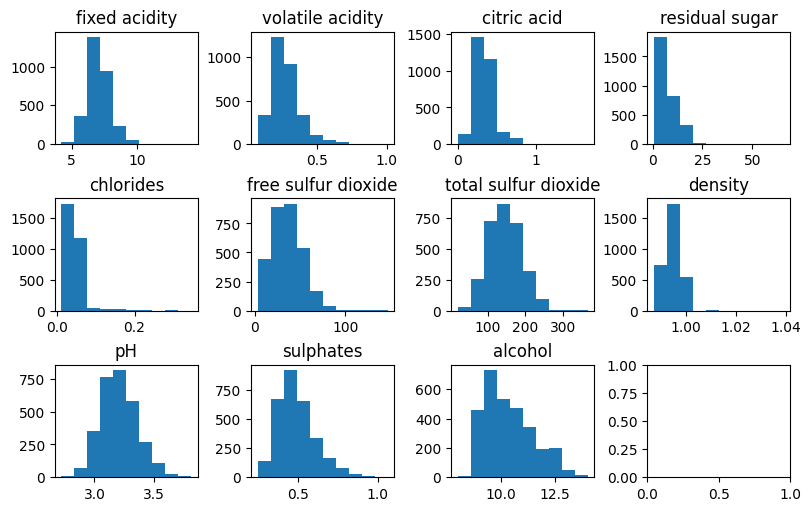

In [6]:
ncols = 4
nrows = 3
idx = 0
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(8.0, 5.0), layout="constrained")

for row in range(nrows):
  for col in range(ncols):
    if idx < 11:
      axs[row, col].hist(Xtrain[:, idx])
      axs[row, col].set_title(names[idx])
      idx += 1

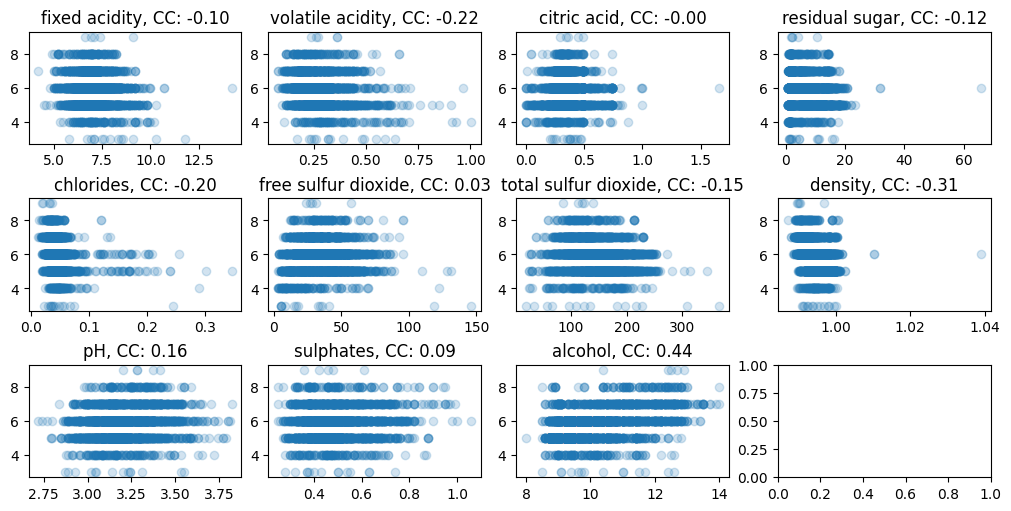

In [7]:
ncols = 4
nrows = 3
idx = 0
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10.0, 5.0), layout="constrained")

for row in range(nrows):
  for col in range(ncols):
    if idx < 11:
      axs[row, col].scatter(Xtrain[:, idx], Ytrain, alpha=0.2)
      c = np.corrcoef(Xtrain[:, idx], Ytrain)[0, 1]
      axs[row, col].set_title(names[idx]+f", CC: {c:.2f}")
      idx += 1

In [8]:
# Least squares best model/fit
print("Shape of Xtrain", Xtrain.shape)
XXinv = np.linalg.inv(np.matmul(Xtrain.T, Xtrain))
print("Shape of inv(XXT)", XXinv.shape)
Wexact = np.matmul(XXinv, np.matmul(Xtrain.T, Ytrain))

print("Shape of best weights Wexact", Wexact.shape)

Shape of Xtrain (3000, 11)
Shape of inv(XXT) (11, 11)
Shape of best weights Wexact (11,)


Text(0.5, 1.0, 'Correlation: 0.5065374544665405')

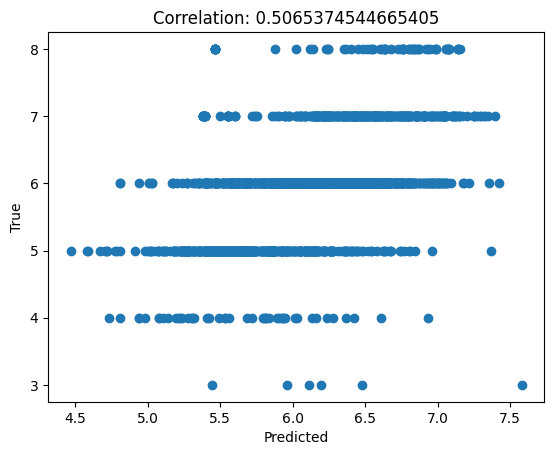

In [9]:
# Predictions on test set
Ypred = np.dot(Xtest, Wexact)
cctest = np.corrcoef(Ypred, Ytest)[0, 1]
plt.scatter(Ypred, Ytest)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Correlation: {cctest}")


In [11]:
Wexact.shape

(11,)

In [135]:
# lets see if we can do better or reproduce the results with a neural network without hidden layers and nonlinearities
# lets push everthing to JAX
jXtrain = device_put(Xtrain)
jYtrain = device_put(Ytrain)

jXtest = device_put(Xtest)
jYtest = device_put(Ytest)
# some random weights
key = random.PRNGKey(42)
jW = random.normal(key, (11, ))



In [136]:
# learning rate
lossi = []
lr = 3e-5
bsize = 512

In [137]:
# lets try now to figure out the weights with SGD and JAX grad functions

# first we need the loss function

def loss(W, X, Y):
 return jnp.sum((jnp.dot(X, W) - Y)**2)

dloss = jax.grad(loss)

#lets quickly check to loss for the least squares solution
print("Loss for least squares solution", loss(Wexact, jXtrain, jYtrain))

Loss for least squares solution 1795.1713


In [138]:
for _ in range(50000):
  new_key, subkey = random.split(key)
  idxs = random.randint(new_key, (512,), 0, len(jYtrain))
  jW = jW - lr/bsize * dloss(jW, jXtrain[idxs], jYtrain[idxs])
  lossi.append(loss(jW, jXtrain, jYtrain))

print(lossi[0], lossi[-1])

4445788.5 30150.434


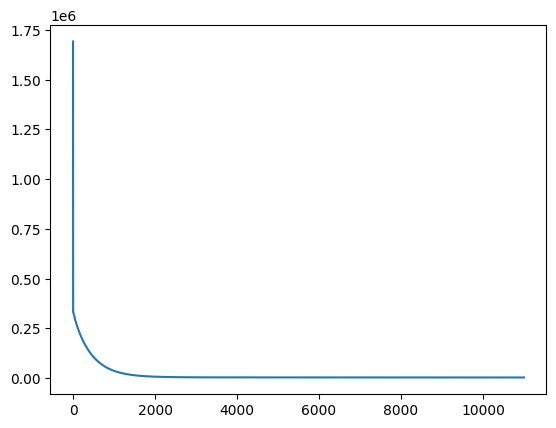

In [50]:
plt.plot(lossi)

Text(0.5, 1.0, 'Correlation: 0.43817932167183654')

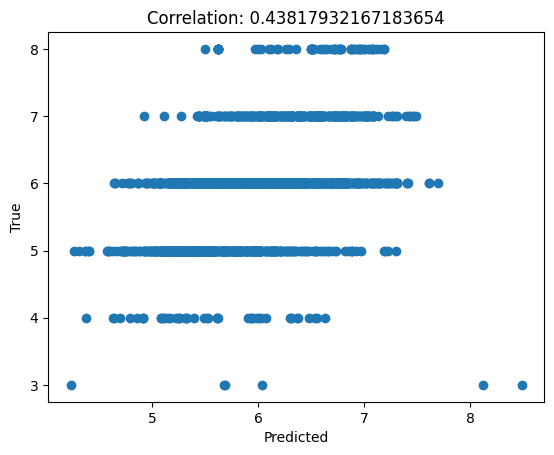

In [57]:
# Predictions on test set
jYpred = jnp.dot(jXtest, jW)
cctest = np.corrcoef(jYpred, jYtest)[0, 1]
plt.scatter(jYpred, jYtest)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Correlation: {cctest}")
